## Import Dependencies


In [320]:
import numpy as np
import scipy.stats as st
from pylab import *
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
import math

## Getting The Kernels - LoG and DoG

In [391]:
def reflecting(matrix):
  n=matrix.shape[0]
  m=matrix.shape[1]
  reflect_mat = np.zeros((n,m))
  for i in range (m):
    reflect_mat[:,i]=matrix[:,m-1-i]
  return reflect_mat

def DoG(sigma):
    filter_size = 2 * int(3 * sigma + 0.5) + 1
    gaussian_filter_1 = np.zeros((filter_size, filter_size), np.float32)
    gaussian_filter_2 = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2
    
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1_a = 2*np.pi*((1.414*sigma)**2)
            x2_a = np.exp(-(x**2 + y**2)/(2* (1.414*sigma)**2))
            gaussian_filter_1[x+m, y+n] = (1/x1_a)*x2_a
            x1_b = 2*np.pi*((sigma)**2)
            x2_b = np.exp(-(x**2 + y**2)/(2* (sigma)**2))
            gaussian_filter_2[x+m, y+n] = (1/x1_b)*x2_b
    return gaussian_filter_1 - gaussian_filter_2

def LoG(sigma):
  
  kernel_size = np.ceil(sigma*6)
  y,x = np.ogrid[-kernel_size//2:kernel_size//2+1,-kernel_size//2:kernel_size//2+1]
  log_y_filter = np.exp(-(y*y/(2.*sigma**2)))
  log_x_filter = np.exp(-(x*x/(2.*sigma**2)))
  log_filter = (-(2*sigma**2) + (x*x + y*y) ) * (log_x_filter*log_y_filter) * (1/(2*np.pi*sigma**4))
  scale_inv_filter = (sigma**2) * log_filter

  plt.imshow(log_filter, cmap="gray")
  plt.show()
  return scale_inv_filter

## Convolution Using Fourier

In [376]:
def dft(image):
  return np.fft.fft(np.fft.fft(image, axis=0), axis=1)

def ifft(image):
  conjugate = np.conj(image)
  original_image = dft(conjugate)/(image.shape[0]*image.shape[1])
          
  return original_image

In [383]:
def convolution( image, kernel):
  image_shape = image.shape
  kernel_shape = kernel.shape
  kernel_pad = np.zeros((image_shape), dtype='float64')
  # Uncomment line 6 and 13 this to get the image left aligned, and comment line 7-10, 12
  #kernel_pad[0:p,0:p] = kernel
  if kernel_shape[0]%2 == 1:
    kernel_pad[int(image_shape[0]/2)-int(kernel_shape[0]/2):int(image_shape[0]/2)+int(kernel_shape[0]/2)+1, int(image_shape[1]/2)-int(kernel_shape[1]/2):int(image_shape[1]/2)+int(kernel_shape[1]/2)+1] = kernel
  else:
     kernel_pad[int(image_shape[0]/2)-int(kernel_shape[0]/2):int(image_shape[0]/2)+int(kernel_shape[0]/2), int(image_shape[1]/2)-int(kernel_shape[1]/2):int(image_shape[1]/2)+int(kernel_shape[1]/2)] = kernel
  fft_image = dft(image.astype('float64')/255.)*dft(kernel_pad.astype('float64'))
  new_img = np.fft.fftshift(np.absolute(ifft(fft_image)))
  #new_img = (np.absolute(ifft(fft_image))
  return new_img

## Obtaining Scale-Space

In [378]:
def generate_scalespace(image,numscales,sigma,k):
  scalespace = []
  for i in range(numscales-1):
    sigma=sigma*k
    kernal=LoG(sigma)
    new_image = convolution(image,kernal)
    scalespace.append(np.square(np.asarray(new_image)))
  return scalespace

## Performing Non-Max Suppression

In [343]:
def non_max_suppression(scalespace,thresh_percent):
  
  kernel=np.ones((3,3),dtype='float64')
  
  scalespace_normalized=[]
  n=len(scalespace)
  for i in range(n):
    dilated = cv2.dilate(scalespace[i], kernel, iterations=1)
    THRH_2D= (np.max(scalespace[i])-np.min(scalespace[i]))*thresh_percent
    #Un-comment this to try a different type of thresholding, also comment the above line
    #THRH_2D= (np.mean(scalespace[i]))
    temp = (scalespace[i]==dilated)*scalespace[i] >= THRH_2D
    scalespace_normalized.append(np.multiply(temp,scalespace[i]))
  scalespace_maxima=np.copy(scalespace_normalized)
  for i in range(n):
    lo=max(0,i-1)
    hi=min(i+1,n-1)
    scalespace_maxima[i,:,:]=np.amax(scalespace_maxima[lo:hi+1,:,:], axis=0)
  centers_bool = scalespace_maxima==scalespace_normalized
  scalespace_nms=np.multiply(scalespace_maxima,centers_bool)
  return scalespace_nms

## Get the Circle Centers

In [372]:
def find_coordinates(scalespace_nms,k,sigma):
  n=len(scalespace_nms)
  for i in range(2,n):
    scale_loc = np.where(scalespace_nms[i]>0)
    scaled_sigma=sigma*k**i
    coordinates=np.zeros((3,len(scale_loc[0])))
    coordinates[0], coordinates[1], coordinates[2] = scale_loc[0], scale_loc[1], scaled_sigma
    coordinates=np.transpose(coordinates)
    coordinates = redundancy(coordinates, 0.01)
    if i == 2:
        final_coordinates = coordinates
    else:
        final_coordinates = np.append(final_coordinates, coordinates, axis=0)
  print(final_coordinates.shape)
  return final_coordinates

## Checking the blob overlap to remove redundancy
Used the code at https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/blob.py as reference to calculae overlap

In [327]:
def blob_overlap( blob1, blob2):
        
        # radius of two blobs
        r1 = blob1[-1] * sqrt(2)
        r2 = blob2[-1] * sqrt(2)
        d = sqrt((blob1[0]-blob2[0])**2 + (blob1[1]-blob2[1])**2)
        
        #no overlap between two blobs
        if d > r1 + r2:
            return 0
        elif d <= abs(r1 - r2):
            return 1
        else:
            #computing the area of overlap between blobs
            ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
            ratio1 = np.clip(ratio1, -1, 1)
            acos1 = math.acos(ratio1)*2
            ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
            ratio2 = np.clip(ratio2, -1, 1)
            acos2 = math.acos(ratio2)*2
            a = -d + r2 + r1
            b = d - r2 + r1
            c = d + r2 - r1
            d = d + r2 + r1
            area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
            return area/(math.pi * (min(r1, r2) ** 2))
        
def redundancy(blobs_array, overlap):
        sigma = blobs_array[:, -1].max()
        distance = 2 * sigma * sqrt(2)
        # Binary search to determine all possible pairs of circles for overlap checking
        tree = spatial.cKDTree(blobs_array[:, :-1])
        pairs = np.array(list(tree.query_pairs(distance)))
        if len(pairs) == 0:
            return blobs_array
        else:
            for (i, j) in pairs:
                blob1, blob2 = blobs_array[i], blobs_array[j]

                if blob_overlap(blob1, blob2) > overlap:
                    if blob1[-1] > blob2[-1]:
                        blob2[-1] = 0
                    else:
                        blob1[-1] = 0
        return np.array([b for b in blobs_array if b[-1] > 0])

## Function used to find blobs

In [374]:
def blobdetecton(image, numscales=10, sigma=1.6,k=np.sqrt(2), thresh_percent=0.035):
    centers = []
    sigmas=[]
    scalespace=generate_scalespace(image,numscales,sigma,k)      
    scalespace_nms=non_max_suppression(scalespace,thresh_percent)
    final_coordinates = find_coordinates(scalespace_nms,k,sigma)
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    
    for center in final_coordinates:
        
        circ = Circle((center[1],center[0]), center[2], color='r', linewidth=0.5, fill=False)
        ax.add_patch(circ)
        
    plt.title('%i circles' % len(final_coordinates))
    plt.show()
    return centers

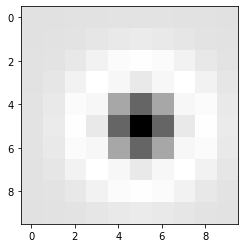

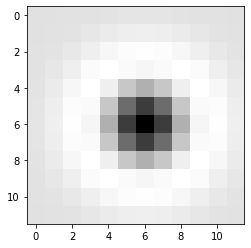

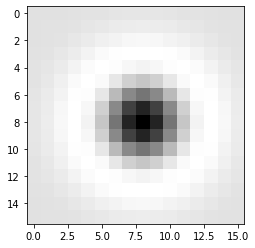

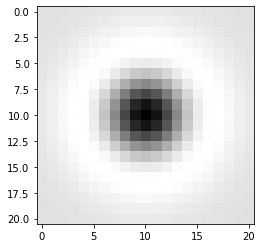

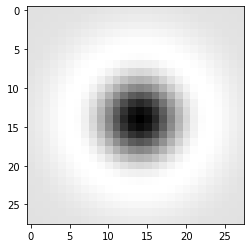

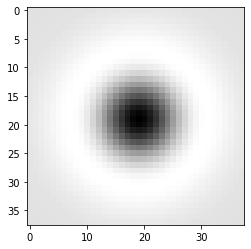

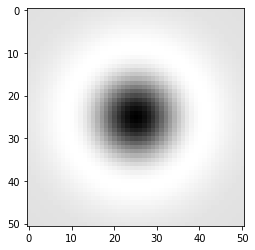

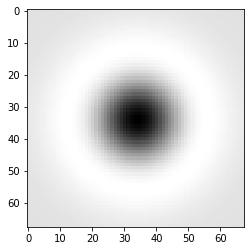

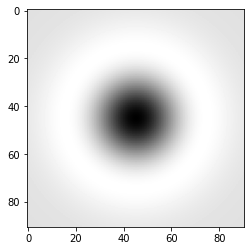

(619, 3)


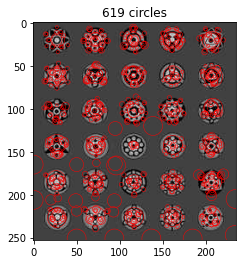

[]

In [412]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/sharingan.jpg",0)
blobdetecton(img, numscales=10, sigma=1,k=1.35, thresh_percent=0.05)

In [ ]:
img = cv2.imread("/content/drive/MyDrive/DIS project/TestImages4Project/einstein.jpg",0)
blobdetecton(img, numscales=10, sigma=1.5,k=1.35, thresh_percent=0.075)

In [ ]:
img = cv2.imread("/content/drive/MyDrive/DIS project/TestImages4Project/fishes.jpg",0)
blobdetecton(img, numscales=10, sigma=1.5,k=1.35, thresh_percent=0.15)

In [ ]:

img = cv2.imread("/content/drive/MyDrive/DIS project/TestImages4Project/butterfly.jpg",0)
blobdetecton(img, numscales=10, sigma=1.5,k=1.35, thresh_percent=0.05)

In [ ]:
img = cv2.imread("/content/drive/MyDrive/DIS project/TestImages4Project/sunflowers.jpg",0)
blobdetecton(img, numscales=10, sigma=1.5,k=1.35, thresh_percent=0.2)

In [ ]:
img = cv2.imread("/content/lanterns2.jpg",0)
blobdetecton(img, numscales=10, sigma=1.5,k=1.35, thresh_percent=0.2)

In [ ]:
img = cv2.imread("/content/scatter.png",0)
blobdetecton(img, numscales=10, sigma=0.7,k=1.35, thresh_percent=0.2)

In [ ]:
img = cv2.imread("/content/circles.jfif",0)
blobdetecton(img, numscales=10, sigma=0.7,k=1.35, thresh_percent=0.5)